In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
etfs = [
    'SPY', 'VGK', 'IEF', 'LQD', 'USO', 'GLD', 'VNQ', 'RWO', 'IWM', 'HYG', 'DBC'
]

adj_close = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)

returns = adj_close.pct_change().dropna()

In [3]:
returns

,DBC,GLD,HYG,IEF,IWM,LQD,RWO,SPY,USO,VGK,VNQ
Date,,,,,,,,,,,
2010-01-05,0.001189,-0.000911,0.004745,0.004391,-0.003438,0.004776,0.004011,0.002647,0.003477,-0.001601,-0.001123
2010-01-06,0.017808,0.016500,0.002585,-0.004036,-0.000941,-0.002947,-0.006146,0.000704,0.013858,0.006014,-0.001798
2010-01-07,-0.012442,-0.006188,0.004037,0.000000,0.007379,0.001239,0.004639,0.004221,-0.006102,-0.006377,0.010806
2010-01-08,-0.000787,0.004963,0.001563,0.001238,0.005454,0.002190,-0.001540,0.003328,0.005157,0.010028,-0.007350
2010-01-11,-0.003152,0.013289,-0.000892,0.000675,-0.004030,0.001045,0.005857,0.001397,-0.009528,0.007943,0.005834
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.018272,0.002998,0.002560,-0.004527,0.004551,-0.003073,0.004429,0.005752,0.023929,0.003246,0.008901
2022-12-27,0.008972,0.008430,-0.010351,-0.008372,-0.006709,-0.012890,0.000245,-0.003943,0.003029,0.001977,-0.000363
2022-12-28,-0.011318,-0.004506,-0.013447,-0.002397,-0.015529,-0.003123,-0.013715,-0.012428,-0.013663,-0.009150,-0.017047


In [4]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

In [5]:
def risk_contribution(weights, cov_matrix):
    portfolio_var = portfolio_variance(weights, cov_matrix)
    marginal_contrib = cov_matrix @ weights
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_var
    return risk_contrib

In [6]:
def objective_function(weights, cov_matrix):
    risk_contrib = risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3847717977700715e-08
            Iterations: 24
            Function evaluations: 306
            Gradient evaluations: 24
Risk Parity Weights:
      Weights
SPY  0.058986
VGK  0.083904
IEF  0.095410
LQD  0.377513
USO  0.040639
GLD  0.133792
VNQ  0.043226
RWO  0.050869
IWM  0.033170
HYG  0.041859
DBC  0.040631


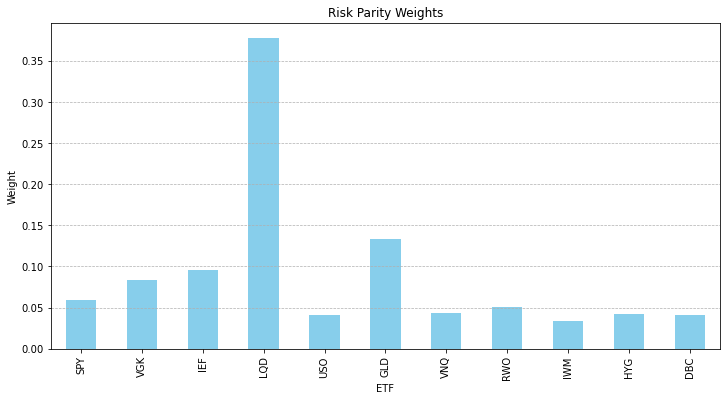

In [7]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

bounds = [(0, 1) for _ in range(len(etfs))]

initial_guess = np.ones(len(etfs)) / len(etfs)

cov_matrix = returns.cov().values

options = {
    'disp': True,   
    'maxiter': 1000,     
}

result = minimize(objective_function, initial_guess, args=(cov_matrix,), constraints=constraints, tol=1e-6, bounds=bounds, options=options)

risk_parity_weights = result.x

risk_parity_weights_df = pd.DataFrame(risk_parity_weights, index=etfs, columns=['Weights'])

print("Risk Parity Weights:")
print(risk_parity_weights_df)

risk_parity_weights_df.plot(kind='bar', legend=False, figsize=(12, 6), color='skyblue')
plt.title('Risk Parity Weights')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.ylabel('Weight')
plt.xlabel('ETF')
plt.show()

In [8]:
import numpy as np

mean_returns = returns.mean()

expected_portfolio_return = np.sum(risk_parity_weights * mean_returns)

portfolio_variance = portfolio_variance(risk_parity_weights, returns.cov().values)

portfolio_risk = np.sqrt(portfolio_variance)

annualized_return = (1 + expected_portfolio_return) ** 252 - 1
annualized_return_percent = annualized_return * 100
print(f"Annualized Expected Portfolio Return: {annualized_return_percent:.2f}%")

annualized_volatility = portfolio_risk * np.sqrt(252)
annualized_volatility_percent = annualized_volatility * 100
print(f"Annualized Portfolio Risk (Volatility): {annualized_volatility_percent:.2f}%")

Annualized Expected Portfolio Return: 4.57%
Annualized Portfolio Risk (Volatility): 6.87%


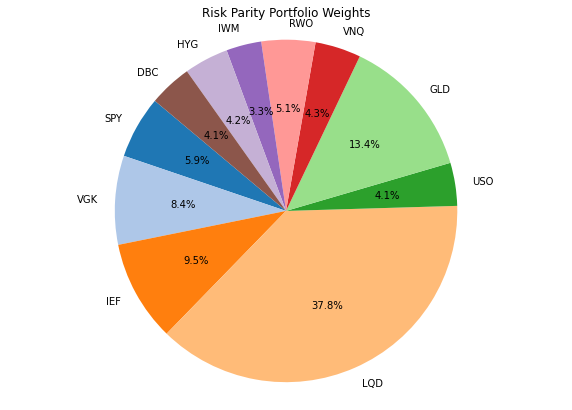

In [9]:
plt.figure(figsize=(10, 7), facecolor='white')
plt.pie(risk_parity_weights, labels=etfs, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Risk Parity Portfolio Weights')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

C:\Users\robby\AppData\Local\Temp/ipykernel_35544/778627500.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in vals])


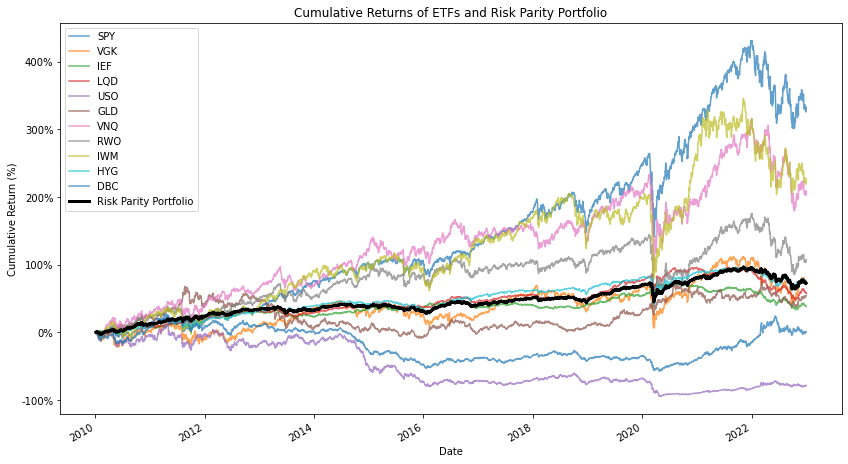

In [19]:
# Calculate cumulative returns of individual ETFs
cumulative_returns = (1 + returns).cumprod() - 1

# Calculate portfolio returns
portfolio_returns = returns.dot(risk_parity_weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1

# Plot cumulative returns in percentage terms
plt.figure(figsize=(14, 8), facecolor='white')
for etf in etfs:
    cumulative_returns[etf].plot(label=etf, alpha=0.7)
cumulative_portfolio_returns.plot(label='Risk Parity Portfolio', linewidth=3, color='black')
plt.title('Cumulative Returns of ETFs and Risk Parity Portfolio')
plt.ylabel('Cumulative Return (%)')
plt.xlabel('Date')
plt.legend()

# Adjust the y-axis to show percentage values
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.show()

In [18]:
1 + returns

,DBC,GLD,HYG,IEF,IWM,LQD,RWO,SPY,USO,VGK,VNQ
Date,,,,,,,,,,,
2010-01-05,1.001189,0.999089,1.004745,1.004391,0.996562,1.004776,1.004011,1.002647,1.003477,0.998399,0.998877
2010-01-06,1.017808,1.016500,1.002585,0.995964,0.999059,0.997053,0.993854,1.000704,1.013858,1.006014,0.998202
2010-01-07,0.987558,0.993812,1.004037,1.000000,1.007379,1.001239,1.004639,1.004221,0.993898,0.993623,1.010806
2010-01-08,0.999213,1.004963,1.001563,1.001238,1.005454,1.002190,0.998460,1.003328,1.005157,1.010028,0.992650
2010-01-11,0.996848,1.013289,0.999108,1.000675,0.995970,1.001045,1.005857,1.001397,0.990472,1.007943,1.005834
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.018272,1.002998,1.002560,0.995473,1.004551,0.996927,1.004429,1.005752,1.023929,1.003246,1.008901
2022-12-27,1.008972,1.008430,0.989649,0.991628,0.993291,0.987110,1.000245,0.996057,1.003029,1.001977,0.999637
2022-12-28,0.988682,0.995494,0.986553,0.997603,0.984471,0.996877,0.986285,0.987572,0.986337,0.990850,0.982953


In [17]:
cumulative_returns

,DBC,GLD,HYG,IEF,IWM,LQD,RWO,SPY,USO,VGK,VNQ
Date,,,,,,,,,,,
2010-01-05,1.001189,0.999089,1.004745,1.004391,0.996562,1.004776,1.004011,1.002647,1.003477,0.998399,0.998877
2010-01-06,1.019017,1.015574,1.007342,1.000337,0.995624,1.001815,0.997840,1.003353,1.017383,1.004404,0.997082
2010-01-07,1.006339,1.009290,1.011409,1.000337,1.002970,1.003056,1.002469,1.007588,1.011175,0.997999,1.007856
2010-01-08,1.005547,1.014299,1.012990,1.001576,1.008440,1.005253,1.000925,1.010941,1.016389,1.008006,1.000449
2010-01-11,1.002377,1.027778,1.012087,1.002252,1.004376,1.006304,1.006788,1.012353,1.006705,1.016013,1.006285
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.005893,1.523315,1.766227,1.400460,3.263699,1.605757,2.061731,4.328907,0.215173,1.758927,3.080983
2022-12-27,1.014919,1.536157,1.747945,1.388736,3.241803,1.585059,2.062236,4.311836,0.215824,1.762405,3.079865
2022-12-28,1.003432,1.529235,1.724440,1.385407,3.191459,1.580109,2.033952,4.258249,0.212876,1.746280,3.027362
